### Import Packages (Temporary)

In [1]:
from pprint import pprint
import spotipy
import spotipy.util as util
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

### Authentication

In [1]:
from get_data import authenticate
sp=authenticate()

### Create Playlist from Playlist ID & Offset Information

In [2]:
# get the playlist ID of the playlist containing all of our liked songs
from get_data import get_target_playlist_id_and_length
playlist_id, total_playlist_length = get_target_playlist_id_and_length(sp)

In [3]:
from get_data import get_data_in_chunks
data = get_data_in_chunks(sp, playlist_id, total_playlist_length)

In [4]:
from get_data import write_to_file
write_to_file(data, 'data/inputs', 'spotify_playlist_data')

### Preprocessing

In [ ]:
only_numbers = master_df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', \
                          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

In [ ]:
def min_max(column_name):
    only_numbers[column_name] = (only_numbers[column_name] - only_numbers[column_name].min())/\
    (only_numbers[column_name].max() - only_numbers[column_name].min())

In [ ]:
for i in only_numbers.columns:
    min_max(i)

<ipython-input-7-1d6ebaf054da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  only_numbers[column_name] = (only_numbers[column_name] - only_numbers[column_name].min())/\


In [ ]:
only_numbers.corr()[(only_numbers.corr() > .7) | (only_numbers.corr() < -0.7)]

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
danceability,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
energy,NaN,1.000000,NaN,0.848457,NaN,NaN,-0.795477,NaN,NaN,NaN,NaN,NaN,NaN
key,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loudness,NaN,0.848457,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mode,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
speechiness,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acousticness,NaN,-0.795477,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
instrumentalness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
liveness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
valence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


From looking at the correlations between these measures, we see that loudness and energy are highly correlated, as well as acousticness and energy. It may be worth it to create new measures from these and drop old, correlated measures.

### Finding Optimal Cluster Number

In [ ]:
cluster = KMeans(n_clusters = 2)
cluster.fit(only_numbers)

KMeans(n_clusters=2)

In [ ]:
empty_scores = []
for i in range (1, 20):
    cluster = KMeans(n_clusters = i)
    cluster.fit(only_numbers)
    empty_scores.append(cluster.inertia_)

In [ ]:
def graph_intertia(data, iterations):
    plt.figure(figsize=(10, 8))
    plt.plot(range(1, iterations), data, color = 'black')
    plt.title('Intertia by Number of Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Intertia')
    plt.show()

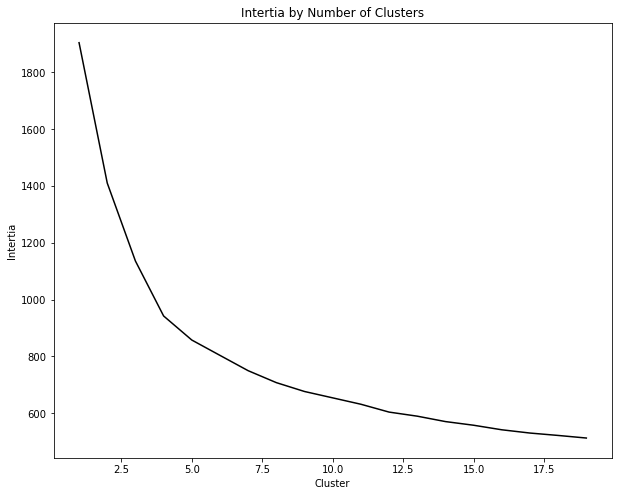

In [ ]:
graph_intertia(empty_scores, 20)

Optimal cluster number is 6.

## Fit and predict on full data

In [ ]:
cluster = KMeans(n_clusters = 6)
predictions = cluster.fit_predict(only_numbers)

In [ ]:
first_run = master_df.copy()

In [ ]:
first_run['Cluster'] = predictions

In [ ]:
import numpy as np
np.random.seed(42)

### Visualizing Clusters

In [ ]:
def plot_clusters(dataframe, measure1, measure2):
    fig = plt.figure(facecolor='white')
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)

    fig.set_figheight(20)
    fig.set_figwidth(20)
    
    # Full Data
    data = dataframe
    scatter = ax2.scatter(x = data[measure1], y = data[measure2], c = data['Cluster'], alpha = .7)
    
    xmax = data[measure1].max() + .05
    xmin = data[measure1].min() - .05

    ymax = data[measure2].max() + .05
    ymin = data[measure2].min() - .05

    ax2.set_xlim([xmin, xmax])
    ax2.set_ylim([ymin, ymax])

    ax2.set_title('Full Data')
    
    # Means
    data = dataframe.groupby(['Cluster']).mean().reset_index().sort_index()
    scatter = ax1.scatter(x = data[measure1], y = data[measure2], c = data['Cluster'])
    legend1 = ax1.legend(*scatter.legend_elements(),
                        loc="best", title="Clusters")
    ax1.add_artist(legend1)
    
    ax1.set_xlim([xmin, xmax])
    ax1.set_ylim([ymin, ymax])
    ax1.set_title('Cluster Means')
    

    
    # Super Title
    fig.suptitle('{} vs. {}'.format(measure1, measure2))
    fig.subplots_adjust(top=0.95)

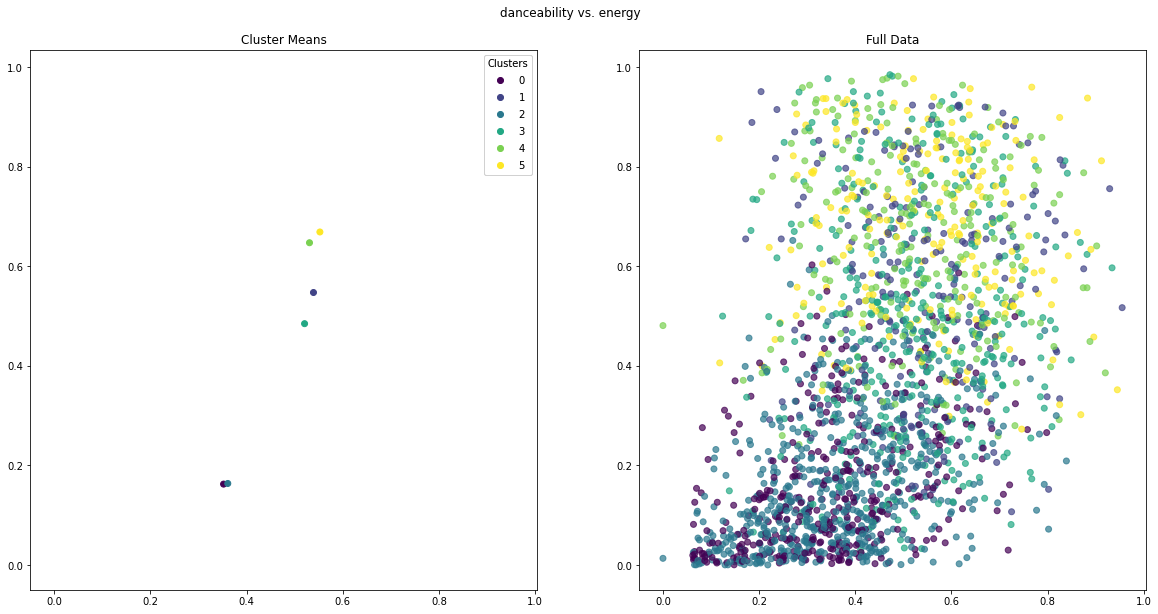

In [ ]:
plot_clusters(first_run, 'danceability', 'energy')

### Create new clusters for playlists

In [ ]:
number_of_clusters = 6

In [ ]:
playlist_df = master_df.copy()

In [ ]:
cluster = KMeans(n_clusters = number_of_clusters)
predictions = cluster.fit_predict(only_numbers)
playlist_df['Cluster'] = predictions

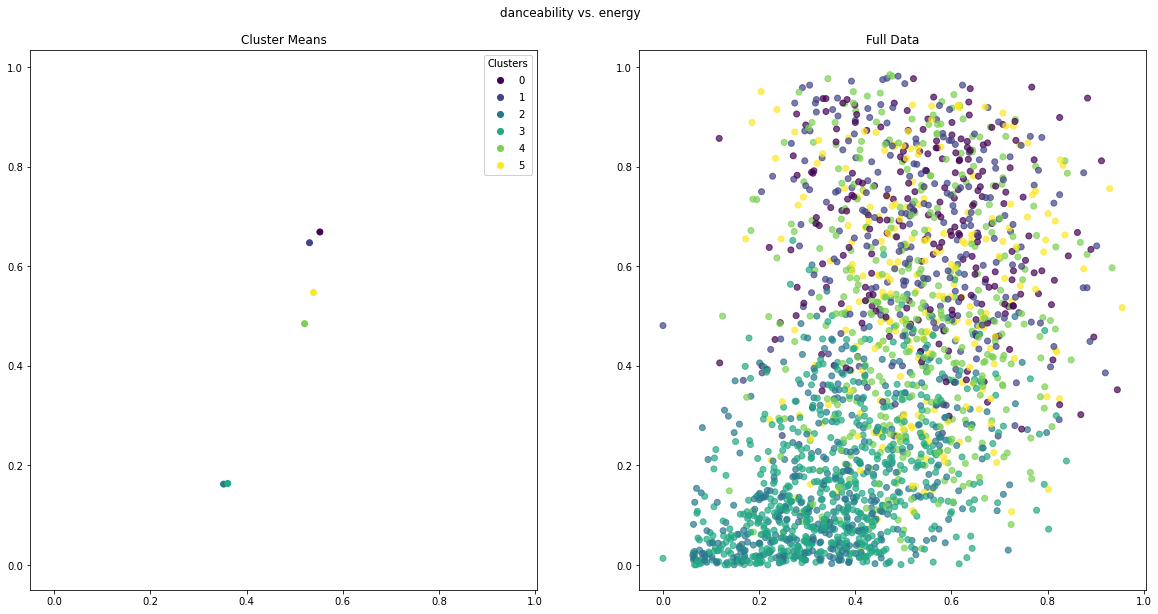

In [ ]:
plot_clusters(playlist_df, 'danceability', 'energy')

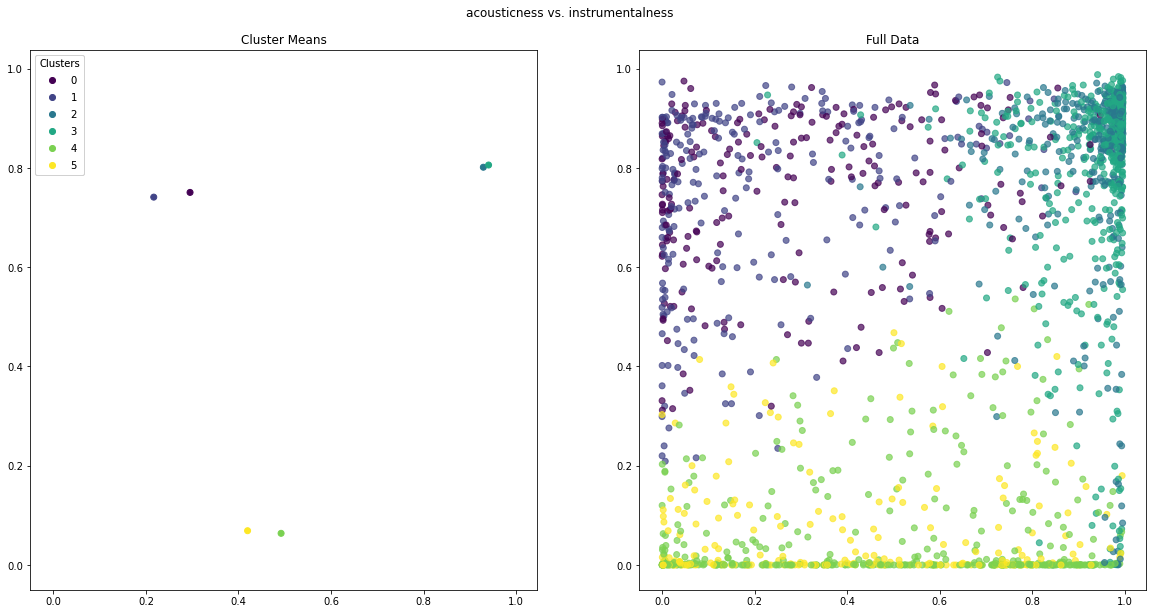

In [ ]:
plot_clusters(playlist_df, 'acousticness', 'instrumentalness')

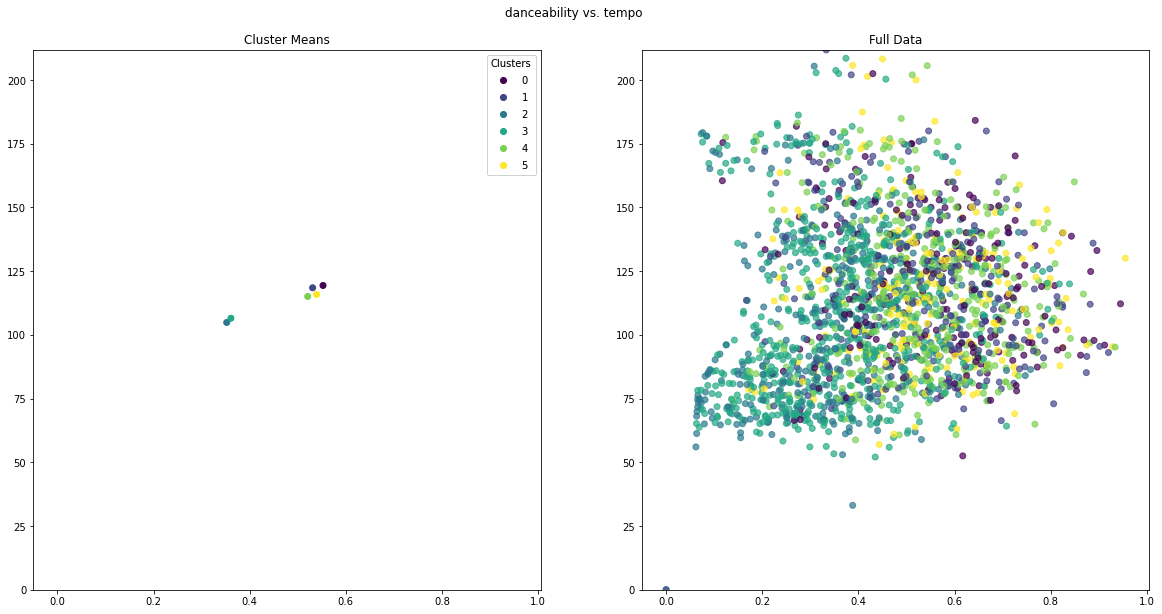

In [ ]:
plot_clusters(playlist_df, 'danceability', 'tempo')

## Export to CSV for further analysis

In [ ]:
first_run.to_csv('Liked Songs with Playlist Clusters.csv')

## Trying alternative method with PCA decomposition and custom gridSearch

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
data = {}

for i in range(1,13):
    PCA_spotify = PCA(n_components=i)
    spotify_clusters = PCA_spotify.fit_transform(only_numbers)
    empty_scores = []
    for j in range(1, 20):
        cluster = KMeans(n_clusters = j)
        cluster.fit(spotify_clusters)
        empty_scores.append(cluster.inertia_)
    data[i] = empty_scores
    
PCA_gridsearch = pd.DataFrame(data)

In [ ]:
PCA_gridsearch

,1,2,3,4,5,6,7,8,9,10,11,12
0,598.518583,1093.343593,1311.573469,1506.585635,1638.084346,1692.848464,1740.246913,1780.307216,1816.086859,1847.052262,1874.758082,1894.269225
1,134.330447,600.785850,818.632398,1012.389678,1143.842365,1198.606451,1246.001855,1286.062093,1321.841588,1352.806129,1380.511929,1400.023050
2,64.063152,327.920355,545.739640,738.475684,869.498809,924.171325,971.496807,1011.552365,1047.299518,1078.260257,1105.994929,1125.467389
3,38.769832,136.178679,353.670581,545.081594,676.109064,730.754898,778.069030,818.117355,853.866013,884.826674,912.523282,932.002582
4,25.039742,94.436091,272.595564,461.550549,591.694116,646.261903,693.415294,733.434560,769.155379,800.093959,827.761906,847.271562
5,17.450385,67.026068,222.073919,407.913270,537.771056,592.351537,639.414536,679.892049,715.146654,746.507328,773.720906,793.241053
6,12.700424,50.928050,172.853531,356.289091,484.742908,539.242248,593.921327,625.902331,661.672325,692.581939,719.972081,739.370776
7,10.303718,40.653299,149.079420,314.930895,443.116361,497.470867,543.928088,586.573255,619.556975,650.471035,677.933690,697.310585
8,8.227695,33.394898,129.139182,288.686579,413.317749,471.289653,518.136184,553.012866,588.407068,619.316770,646.788789,666.118210
9,6.491223,28.455760,113.998562,265.297293,387.487152,448.382916,487.335050,526.674177,562.169343,596.470534,620.525264,639.872071


Graph intertia for a specific number of principal components.

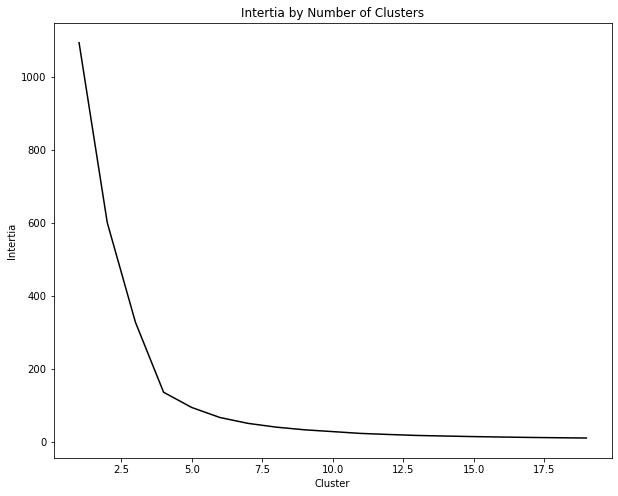

In [ ]:
graph_intertia(PCA_gridsearch[2], 20)

In [ ]:
PCA_predictions = master_df.copy()

PCA_spotify = PCA(n_components=2)
spotify_clusters = PCA_spotify.fit_transform(only_numbers)
PCA_predictions['PCA_1'] = spotify_clusters[:,0]
PCA_predictions['PCA_2'] = spotify_clusters[:,1]
cluster = KMeans(n_clusters = 6)
predictions = cluster.fit_predict(spotify_clusters)
PCA_predictions['Cluster'] = predictions

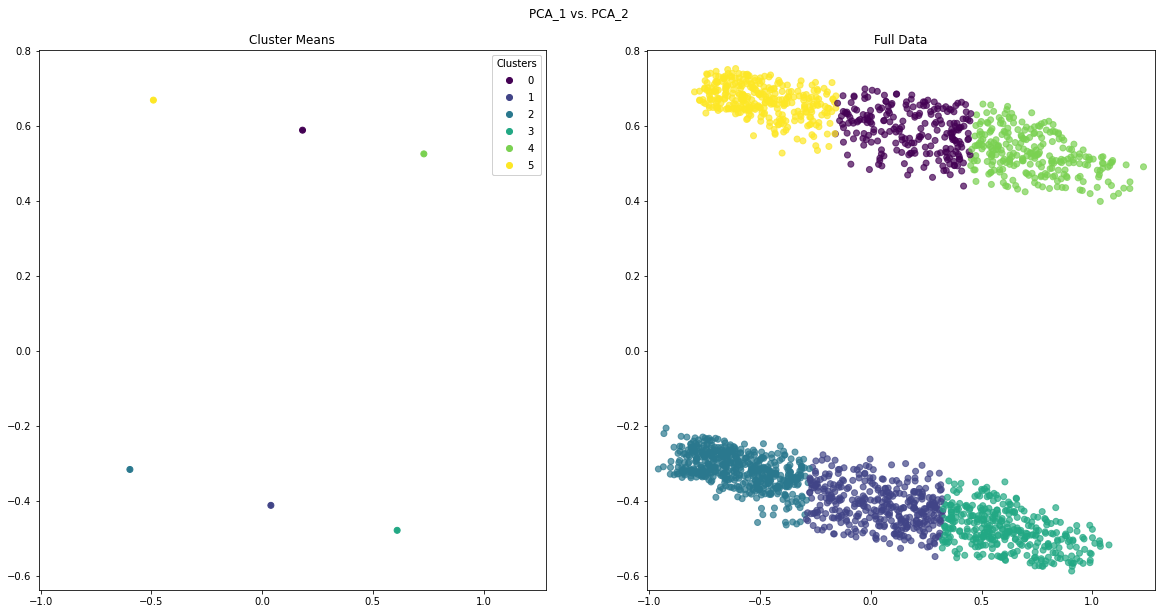

In [ ]:
plot_clusters(PCA_predictions, 'PCA_1', 'PCA_2')

Struggling to interpret this here - it's interesting to see that inertia overall is lower for number_of_clusters = 6, but because we decomposed into two PC's, we find it much harder to select a specific playlist based on its features (i.e selecting a high danceability playlist).

For this reason, I'd stick with the k-means (no PCA) method of clustering for new playlist creation.

### Send Cluster to Playlist

In [ ]:
def cluster_to_playlist(title, data, cluster_id):
    # Creates playlist
    playlist_id = sp.user_playlist_create(username, title, public=True, collaborative=False, \
                            description='Cluster {} from ML Project'.format(cluster_id))['id']
    # Get tracklist
    items = list(data[data['Cluster'] == cluster_id]['track_id'])
    if len(items) < 100:
        sp.playlist_add_items(playlist_id, items, position=None)
    else:
        while True:
            if items != []:
                try:
                    write = items[:100]
                    sp.playlist_add_items(playlist_id, write, position=None)
                    del items[:100]
                except:
                    break
            else:
                break

In [ ]:
cluster_to_playlist('Cluster 4 of PCA analysis', PCA_predictions, 4)

In [ ]:
cluster_to_playlist('Cluster 4 of K-means without PCA', playlist_df, 4)